In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class Model():

    def __init__(self, **kwargs):
        self.terms = ['IA', 'IE', 'CA', 'NPAE', 'AW', 'AN', 'TF']
        self.sky_rms = 0.0
        self.model_date = None
        self.total_geometric_terms = 0
        self.total_terms = 0
        self.total_obs = 0
        if 'path' in kwargs:
            self.read_model(kwargs['path']) 

    def read_model(self, path):
        self.path = path
        self.name = self.path.split('/')[-1].split('.')[0]
        with open(path, 'r') as f:
            lines = f.readlines()
        _, self.model_date = lines[0].split(' ', 1)
        dat = lines[1].split()
        self.total_obs, self.sky_rms = [float(dat[i]) for i in range(1,3)]
        self.total_obs = int(self.total_obs)
        lines = lines[2:-1]
        
        d = {}
        for i, line in enumerate(lines):
            term, val, std = line.strip().split()
            d[term] = np.array([float(val), float(std)])
            if term in self.terms:
                self.total_geometric_terms += 1
            self.total_terms += 1
        
        self.full_frame = pd.DataFrame(d, index=['Value', 'SE']).T
        df = self.full_frame.loc[self.terms]
        self.frame = df

    def show_model(self):
        l = len('Sky RMS pointing accuracy    : {}'.format(self.sky_rms)) + 1
        
        print('No. of observations in model : ', self.total_obs)
        print('No. of terms in model        : ', self.total_terms)
        print('Sky RMS pointing accuracy    : ', self.sky_rms)
        print('-'*l)
        print(self.frame)
        print('-'*l, '\n')
            
    def compare_model(self, model, skip_constants=True, constants_only=False, full_compare=False):
        
        if constants_only:
            df1 = self.frame.loc[['IE', 'IA']]
            df2 = model.frame.loc[['IE', 'IA']]
        elif skip_constants:
            df1 = self.frame.drop(['IE', 'IA'])
            df2 = model.frame.drop(['IE', 'IA'])
        else:
            df1 = self.frame
            df2 = model.frame
            
        d = {'model1' : df1.iloc[:, 0], 'model2' : df2.iloc[:, 0]}
        cmp = pd.DataFrame(d)
        cmp['diff'] = d['model1'] - d['model2']
        mod1 = self.name
        mod2 = model.name
        print('Model 1 is {} \nModel 2 is {}'.format(mod1, mod2))
        print(cmp)
        
    def show_bar(self, *models, skip_constants=True, constants_only=False):
        
        models = list(models)
        frames = list()
        bars = list()
        mod_names = list()
        for model in models:
            if constants_only:
                df1 = self.frame.loc[['IE', 'IA']]
                df2 = model.frame.loc[['IE', 'IA']]
            elif skip_constants:
                df1 = self.frame.drop(['IE', 'IA'])
                df2 = model.frame.drop(['IE', 'IA'])
            else:
                df1 = self.frame
                df2 = model.frame
            df2.fillna(0, inplace=True)
            frames.append(df2)
        
        frames = [df1] + frames

        models = [self] + models
        
        ind = np.arange(df1.shape[0])
        width = 1/(len(frames)+1)
        
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 8)
        ax.grid()
        ax.set_xticks(ind + (len(frames)-1)*width/2)
        ax.set_xticklabels(tuple(df1.index))
        colors = ['b', 'r', 'y', 'g', 'm', 'c']
        
        for i, frame in enumerate(frames):
            mod = models[i]
            index = ind + i*width
            yerr = frame.SE * stats.t.ppf(1-0.05/2,  mod.total_obs - mod.total_terms)
            #print(frame.Value)
            bar = ax.bar(index, frame.Value, width, color=colors[i], yerr=yerr)
            bars.append(bar)
        ax.legend([bar[0] for bar in bars], [model.name for model in models])
        plt.show()
        
        

In [276]:
m1 = Model(path='/home/mohan/projects/ARIES/data-folder-tcspc/pointing/20151129_MainPort/MainPort_20151129.mod')
#m1.show_model()
m2 = Model(path='/home/mohan/projects/ARIES/data-folder-tcspc/pointing/20151104_SP1/SidePort1_20151104.mod')
#m1.show_model()
#m2.compare_model(m1)

Model 1 is MainPort_20151129 
Model 2 is Imager_20170320
       model1   model2     diff
CA     6.2033  24.8225 -18.6192
NPAE  19.0718      NaN      NaN
AW    25.2111  35.4935 -10.2824
AN   -49.0799 -52.9430   3.8631
TF   -50.4026 -52.2000   1.7974


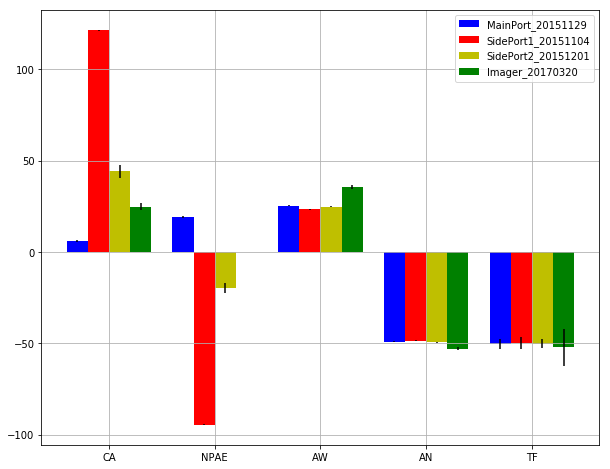

In [278]:
m3 = Model(path='/home/mohan/projects/ARIES/data-folder-tcspc/pointing/20151201_SidePort2/SidePort2_20151201.mod')
m4 = Model(path='/home/mohan/Downloads/pointing/20170320_Imager/Imager_20170320.mod')
m1.compare_model(m4)
m1.show_bar(m2, m3,m4)